<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance de caractères manuscrits](https://github.com/wikistat/Ateliers-Big-Data/2-MNIST) ([MNIST](http://yann.lecun.com/exdb/mnist/)) par apprentissage épais (*deep learning*) avec <a href="https://www.tensorflow.org/"><img src="https://avatars0.githubusercontent.com/u/15658638?s=200&v=4" width=100, style="display: inline" alt="TensorFlow"/></a> tensorflow et  <a href="https://keras.io/"><img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" width=250, style="display: inline" alt="Keras"/></a> Keras


## Introduction

### Objectif
Ce calepin reprend le même objectif que les calepins de l'[Atelier MNIST](https://github.com/wikistat/Ateliers-Big-Data/tree/master/2-MNIST) et sur les mêmes données mais en utilisant cette fois les librairies `Keras` et `TensorFlow` pour aborder l'apprentissage profond. Il est une adpatation du tutoriel de Keras.

###  Importation des librairies

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import pandas as pd
import numpy as np
import time

import keras.utils as ku
import keras.models as km
import keras.layers as kl
import keras.optimizers as ko

from sklearn.metrics import confusion_matrix

# Paramètres
batch_size = 128
epochs = 10
# Vocabulary
# One epoch is when an ENTIRE dataset is passed forward and backward through neural network only once
# Batch_size : total number of training examples present in a single batch. 
# Batch_size : defines the number of samples to work through before updating the internal model parameters
# Batch_size : is the number of samples processed before the model is updated. 



import sys
print(sys.version)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 56685896494297430
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 78774272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11169545864343040259
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [1]:
import tensorflow
tensorflow.__version__

'1.13.0-rc2'

### Lecture des données d'apprentissage et de test

Les données peuvent être préalablement téléchargées ou directement lues. Ce sont celles originales du site [MNIST DataBase](http://yann.lecun.com/exdb/mnist/) mais préalablement converties au format .csv, certes plus volumineux mais plus facile à lire. Attention le fichier `mnist_train.zip` présent dans le dépôt est compressé. 

In [6]:
# Lecture des données d'apprentissage
N_classes = 10

# path="" # Si les données sont dans le répertoire courant sinon:
path=""
Dtrain=pd.read_csv(path+"mnist_train.zip",header=None)

X_train = Dtrain.values[:,:-1] # Reprend tout le tableau sauf la dernière colonne 
Y_train = Dtrain.values[:,-1] # Récupère la dernière colonne du tabelau qui correspond à ? 

Dtest=pd.read_csv(path+"mnist_test.csv",header=None)
X_test = Dtest.values[:,:-1]
Y_test = Dtest.values[:,-1] # label


*Attention*, avec Keras, la variable réponse doit être une matrice binaire où chaque classe est représentée par une indicatrice: pour chaque individu, l'élément de la colone correspondant à la classe à laquelle il appartient est à 1, sinon il est à 0. 

Keras possède une fonction `to_catergorical` permettant de convertir directement le vecteur variable `Y_train` de réponse en matrice (`array numpy`) indicatrice`Y_train_cat`.

C'est l'équivalent de `get_dummies` de `pandas`
 ou `OneHotEncoder` de `scikit-learn`. 

In [7]:
Y_train_cat = ku.to_categorical(Y_train, N_classes) # convert a class vector to binary class matrix
Y_test_cat = ku.to_categorical(Y_test, N_classes) # Nombre de colonne correspond au nombre de classe
# le nombre de lignes de la matrice correspond au nombre d'éléments du vecteur original. 
# Chaque ligne corespond à un élément du vecteur initial si cet élément appartient à la j-ème classe
# ie la j-ème colonne on met 1 le reste sera par des 0.

## Apprentissage et prévision du test Avec réseau dense

Première tentative d'appliquer un réseaux de neurone de type Perceptron classique avec 4 couches: 
* Dense: 52 neurones + Foncton d'activation *relu*
* *Dropout*: 20% des neurones tiré aléatoirement sont desactivés
* Dense: 52 neurones + Foncton d'activation *relu*
* *Dropout*: 20% des neurones tiré aléatoirement sont desactivés

Une dernière couche *softmax* fournit la classification

** Remarque ** : 

Dropout layer : desactivate 20 % of neurons during the training, in order to force our layer to learn the same concept with different neurons.  

### Apprentissage

In [8]:
X_train.shape

(60000, 784)

In [9]:
# Définition du réseau
model = km.Sequential()
model.add(kl.Dense(128, activation='relu', input_shape=(784,)))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(N_classes, activation='softmax'))
# Réumé
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


**Q** Retrouvez manuellement le nombre de paramètres.

<br>
<font color="#0080FF">
On part d'une image de taille $28\times 28$ dont chaque pixel est disposé selon un vecteur de $\mathbb{R}^{784}$. On applique à ce vecteur le premier filtre, de taille 128. Ainsi, on obtient $784 \times 128 + 128 = 100 480$ paramètres.

Ensuite, on a donc un vecteur sortant du filtre 1 de taille 128, que l'on passe dans le filtre 2, ce qui donne $128 \times 128 + 128 = 16512$ paramètres. 

En sortie, on remarque que la valeur souhaitée est de 10, donc on a bien $128 \times 10 + 128 = 1290$ paramètres.
</font>


In [10]:
# apprentissage
model.compile(loss='categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])
ts = time.time()
history = model.fit(X_train, Y_train_cat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test_cat))
te = time.time()
t_train_mpl = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 162us/step - loss: 6.6015 - acc: 0.5810 - val_loss: 4.6322 - val_acc: 0.7053
Epoch 2/10
60000/60000 [==============================] - 3s 55us/step - loss: 4.7540 - acc: 0.6997 - val_loss: 4.3884 - val_acc: 0.7246
Epoch 3/10
60000/60000 [==============================] - 3s 56us/step - loss: 4.5095 - acc: 0.7167 - val_loss: 4.0687 - val_acc: 0.7460
Epoch 4/10
60000/60000 [==============================] - 3s 55us/step - loss: 4.4154 - acc: 0.7234 - val_loss: 3.9602 - val_acc: 0.7525
Epoch 5/10
60000/60000 [==============================] - 3s 55us/step - loss: 4.2780 - acc: 0.7319 - val_loss: 3.8718 - val_acc: 0.7584
Epoch 6/10
60000/60000 [==============================] - 3s 58us/step - loss: 4.1804 - acc: 0.7384 - val_loss: 3.7921 - val_acc: 0.7632
Epoch 7/10
60000/60000 [==============================] - 4s 59us/step - loss: 4.1194 - acc: 0.7423 - val_loss: 3.8186 - val_a

On remarque : 

* Décroissance pour les valeurs loss et val loss tout au long des epochs 
* Croissance des valeurs acc et val_acc tout au long des epochs 

Ainsi on arrive à faire décroitre la fonction de perte tout au long de l'entrainement et accroitre l'exactitude de notre modèle. 

### Résultats

Test loss: 3.7269242885589597
Test accuracy: 0.7678
Time Running: 41.34 seconds


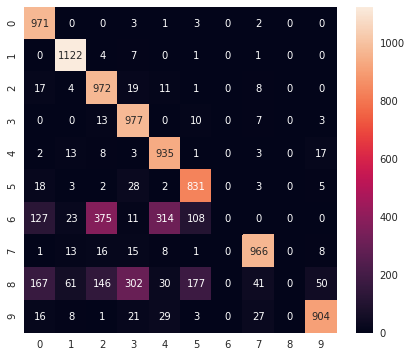

In [11]:
score_mpl = model.evaluate(X_test, Y_test_cat, verbose=0)
predict_mpl = model.predict(X_test)
print('Test loss:', score_mpl[0])
print('Test accuracy:', score_mpl[1])
print("Time Running: %.2f seconds" %t_train_mpl )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_mpl.argmax(1))), annot=True, fmt="d")


**Q** Que dire de ces résultats ? 
 <font color="#0080FF">
* Les résultats obtenus montrent que sur la diagonale, les valeurs sont celles qui, en moyenne, ont des valeurs importantes. Ainsi, cela montre que l'estimation du vecteur obtenu est correcte, hormis pour le caractère 4 et 6. 


* Confusion matrix  is such as C_i,j is equal to the number of observations known to be in group i but predicted to be in group j, the coefficient on the diagonal represent the  number of elements the model has managed to predict exactly. 

* On remarque que le modèle n'arrive pas à prédire proprement les éléments apparetenant à la classe 7. </font>

**Q** Faites tourner de nouveaux l'algorithme en normalisant les données afin que celles-ci soit comprises entre 0 et 1. Qu'observez vous?

## Convolutional Layers

#### Format des données

Dans les exemples précédents. Les données était "applaties". Une imade de $28\times 28=784$ pixels est considérée comme un vecteur. 

Pour pouvoir utiliser le principe de la convolution la structure des images est conservée. Une image n'est pas un vecteur de tailles $784\times 1$ mais une matrice de taille $28\times 28$. Une troisième dimension est également nécessaire pour décrire afin de prendre en compte les différents `channels` de l'image. Dans le cas de `MNIST` cette dernière dimension est de taille 1 car les pixels ne sont décrits qu'avec un seul niveau de gris. Cependant, des images couleurs en RGB sont généralement codées avec trois niveaux d'intensité (Rouge, Vert et Bleus).


Ainsi `X_train` est réorganisée en cube ou multitableau de dimensions $60000\times 28\times 28\times 1$ pour être utilisé dans un réseau de convolution avec `Keras`.


In [12]:
X_train_conv = X_train.reshape(60000, 28, 28, 1)
X_test_conv = X_test.reshape(10000, 28, 28, 1)

Visualisation des données

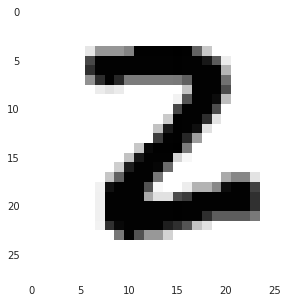

In [13]:
import keras.preprocessing.image as kpi
fig  = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
x = kpi.img_to_array(X_train_conv[0])
ax.imshow(x[:,:,0]/255, interpolation='nearest', cmap="binary")
ax.grid(False)
plt.show()

### Edge detection

Dans cette partie vous pouvez explorer l'effet de filtre de convolution simple sur une image.

Un réseau de neuronne constitué d'une couche de convolution constitué d'un seul filtre définie manuellement (non appris par optimisation) est définie dans le code ci-dessous.

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D

conv_filter = np.array([
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_edge = Sequential([
    Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1))   
])

**Q** Notez que dans la fonction `my_init_filter` les dimensions de l'image sont modifiés. A quoi correspondent les deux dimensions ajoutées?

* <font color="#0080FF">La première dimension ajoutée correspond aux filtres de la couleur.</font>

* La deuxième dimension correspond à la taille du batch, ici on traite une image à chaque fois. 

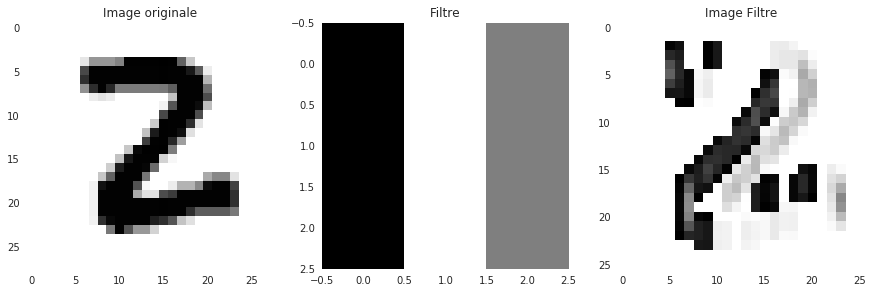

In [15]:
img_in = np.expand_dims(x, 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)


**Q** Que constatez vous? Verifiez que les dimensions de l'image en sortie sont cohérentes.

<font color="#0080FF">On constate que l'image obtenue en sortie met en avant les zones de l'image initiale qui présentent des niveaux de gris différents selon l'axe vertical.</font>

**Q** Testez ce même code avec un filtre différent.

<font color="#0080FF">On peut aussi utiliser un filtre différent, l'inverse du filtre précédent, c'est à dire suivant l'axe horizontal, pour analyser les résultats complémentaires. </font>

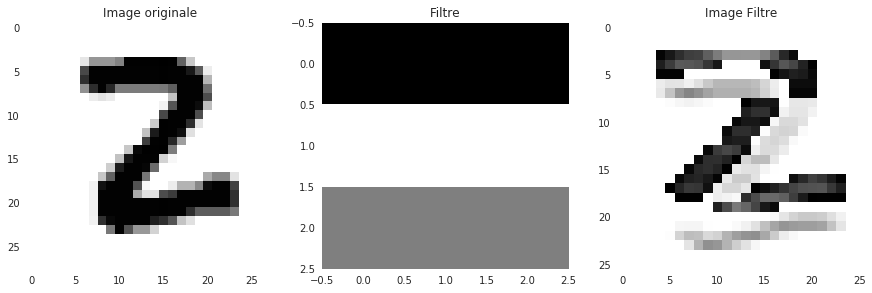

In [16]:
conv_filter = np.array([
        [0.2, 0.2, 0.2],
        [-0.2, -0.2, -0.2],
        [0, 0, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_edge = Sequential([
    Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1))   
])

img_in = np.expand_dims(x, 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)

### Strides and Padding

Dans cette partie vous pouvez explorer l'effet des arguments `strides`et `padding` sur une image.


In [17]:
from keras.models import Sequential
from keras.layers import Conv2D

conv_filter = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_sp = Sequential([
    Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1),
           strides=2,
           padding="SAME") ])

**Q** Quel est l'effet du filtre défini ici? 

<font color="#0080FF">Le filtre a ici un effet de grossissement de l'image, ce qui permet de résuire les dimensions tout en conservant l'aspect général de l'image de base.</font>

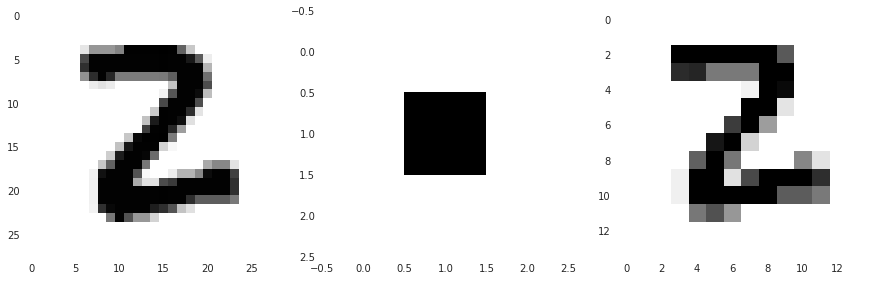

In [18]:
img_in = np.expand_dims(x, 0)
img_out = conv_sp.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8),
           cmap="binary");
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax2.grid(False)

**Q** Modifiez les paramètres `stride`et `padding`, et observez l'effet sur la dimension des images. 

<font color="#0080FF">Lorsque l'on modifie le nombre de strides, on augmente le grossissement de l'image : en effet, si le stride est égal à 1, l'image reste inchangée mais elle peut perdre en dimension, cela dépend du padding. Si on utilise un stride égal à 2, les dimensions de l'image sont alors égale à $24/2 = 12$ et si le stride est égal à 3, on a une image en sortie de taille $24/3 = 8$.</font>

<font color="#0080FF">Ensuite, le padding lui permet de rajouter ou non une bordure de $0$, pour ne pas perdre en dimension. En effet, si le padding est égal à 1, alors une bordure de 0 est ajoutée.</font> 

### Max Pooling

**Exercice** Ecrivez un code similaire pour observez l'effet du MaxPooling.

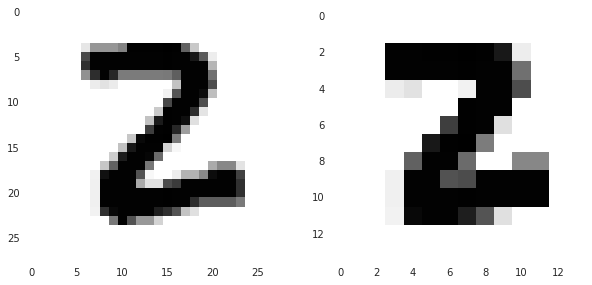

In [19]:
# %load max_pooling.py
from keras.layers import MaxPool2D
conv_mp = Sequential([ MaxPool2D(pool_size=(2,2))])

img_in = np.expand_dims(x, 0)
img_out = conv_mp.predict(img_in)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

ax1.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax1.grid(False)

## *Convolutional Network (ConvNet)*
Les propriété d'invariance par translation introduites par les couches opérant une convolution des images ont un impact important sur la qualité des résultats.

### LeNet5

On teste dans un premier temps le modèle LeNet5 proposer par LeCun et al.

In [20]:
LeNet5model = km.Sequential()
LeNet5model.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',
input_shape = (28,28,1)))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Flatten())
LeNet5model.add(kl.Dense(units = 120, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 84, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 10, activation = 'softmax'))

LeNet5model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_5 (Dense)              (None, 84)                10164     
__________

**Q** Retrouvez manuellement le nombre de paramètres.

* Conv layers formula : $$\text{numbers of parameters} = \text{output_channels} \cdot (\text{input_channels} \cdot \text{Window_size} + 1)$$



* Dense layers formula : $$ \text{numbers of parameters} = \text{output_size} \cdot (\text{input_size} + 1)$$


* First layer, (conv layers), Param = 6 x ( 1 x (5 x 5) + 1) = 156



* The second layer,(conv layers), Param =  16 x ( 6 x (5 x 5) + 1)= 2416



* The third layer, (dense layer), Param = 120 x (256 + 1)= 30840



* The fourth layer, (dense layer), Param = 84 x (120 + 1) = 10164



* The fifth layer, (dense layer), Param =  10 x (84 + 1) = 850




**Q** Que dire du nombre de paramètres de ce réseau par rapport au réseau dense précédement défini?

* On se retrouve avec beaucoup moins de paramètres que le réseau défini précédemment malgré qu'on ait plus  de couches. Le nombre de paramètres a été réduit grâce à l'utilisation de la couche maxpooling. 

In [21]:
# Apprentissage
LeNet5model.compile(loss="categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
LeNet5model.fit(X_train_conv, Y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test_cat))
te=time.time()
t_train_conv = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.2700 - acc: 0.9208 - val_loss: 0.1027 - val_acc: 0.9685
Epoch 2/10
60000/60000 [==============================] - 5s 75us/step - loss: 0.0858 - acc: 0.9737 - val_loss: 0.0730 - val_acc: 0.9768
Epoch 3/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0612 - acc: 0.9805 - val_loss: 0.0547 - val_acc: 0.9823
Epoch 4/10
60000/60000 [==============================] - 4s 75us/step - loss: 0.0494 - acc: 0.9844 - val_loss: 0.0566 - val_acc: 0.9818
Epoch 5/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.0402 - acc: 0.9866 - val_loss: 0.0509 - val_acc: 0.9834
Epoch 6/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0322 - acc: 0.9897 - val_loss: 0.0476 - val_acc: 0.9856
Epoch 7/10
60000/60000 [==============================] - 4s 74us/step - loss: 0.0269 - acc: 0.9912 - val_loss: 0.0492 - val_acc

**Q** Que dire du temps de calcul? Pourquoi est-il plus long que le réseau Dense?

#### Résultats

In [ ]:
score_conv = LeNet5model.evaluate(X_test_conv, Y_test_cat, verbose=0)
predict_conv = LeNet5model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")


### Autre architecture

#### Réseau
Test d'un réseau de convolution constitué de 7 couches: 

* Une couche de convolution 2D, avec fenêtre de taille 3x3 et une fonction d'activation *relu*
* Une couche de convolution 2D, avec fenêtre de taille 3x3 et une fonction d'activation *relu*
* Une couche max pooling de fenêtre 2x2
* Une couche *dropout* où 25% des neurones sont desactivés
* Une couche *Flatten* transforme les images $N \times N$ en vecteurs $N^2$.
* Une couche classique de 128 neurones
* Une couche dropout ou 50% des neurones sont desactivés

Une couche *softmax* fournit la classification

** Vocabulary ** :

* Poolinglayer : is often used to reduce the spatial dimensions, which enable us to gain computaion performance, and to have less chance to over-fit. 

In [ ]:
# descrition du réseau
model = km.Sequential()
model.add(kl.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28, 1), data_format="channels_last"))
model.add(kl.Conv2D(64, (3, 3), activation='relu'))
model.add(kl.MaxPooling2D(pool_size=(2, 2)))
model.add(kl.Dropout(0.25))
model.add(kl.Flatten())
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dropout(0.5))
model.add(kl.Dense(N_classes, activation='softmax'))
# Résumé
model.summary()
# Apprentissage
model.compile(loss="categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
model.fit(X_train_conv, Y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test_cat))
te=time.time()
t_train_conv = te-ts

In [ ]:
score_conv = model.evaluate(X_test_conv, Y_test_cat, verbose=0)
predict_conv = model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")

**Q** Commenter les résultats. Comparer avec les autres techniques d'apprentissage.

**Paramètres**

* Conv layers formula : $$\text{numbers of parameters} = \text{output_channels} \cdot (\text{input_channels} \cdot \text{Window_size} + 1)$$



* Dense layers formula : $$ \text{numbers of parameters} = \text{output_size} \cdot (\text{input_size} + 1)$$


* First layer, (conv layers), Param = 32 x ( 1 x (3 x 3) + 1) = 320



* The second layer,(conv layers), Param =  64 x ( 32 x (3 x 3) + 1)= 18 496



* The third layer, (dense layer), Param = 128 x (9216 + 1)= 1 179 776



* The fourth layer, (dense layer), Param = 10 x (128 + 1) = 1 290



 

**Q** Comment améliorer encore ces résultats?